# Seeing the World Through Language: Object Detection with Grok 👁️ + 🌍

Today, we’re diving into a somewhat unorthodox application of LLMs: pushing Grok to see the world through a visual lens. Object detection? That’s the domain of [CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network) and vision models armed with bounding box superpowers, right? So why unleash an LLM on this challenge?

By combining Grok’s vast world knowledge with object detection, we enable language-driven vision. This unlocks capabilities such as analyzing an image with multiple languages and detecting only specific ones, identifying animals in a flock with a certain posture, or pinpointing a specific model of a car brand, these are tasks that traditional vision models simply can’t achieve. Check out the examples below to see this in action!

> ℹ️ **Note**: This cookbook is designed to showcase what can be possible with good prompting and a dash of creativity. That said, results may not always be accurate, and you might get different outcomes if you try these examples yourself. Think of this as an experimental playground rather than a precise tool.

All images in this cookbook are courtesy of [Unsplash](https://unsplash.com/license).

## Table of Contents

- [Code Setup](#code-setup)
- [Counting Objects in a Complex Scene](#counting-objects-in-a-complex-scene)
- [Detecting Objects in a Complex Scene](#detecting-objects-in-a-complex-scene)
  - [Approach](#approach)
- [The Power of Vision-Based Object Detection](#the-power-of-vision-based-object-detection)
  - [Niche Object Detection](#niche-object-detection)
  - [Applying Arbitrary Criteria](#applying-arbitrary-criteria)
  - [Text in Images with Multilingual Awareness](#text-in-images-with-multilingual-awareness)
- [Conclusion](#conclusion)

In [2]:
%pip install --quiet IPython openai pydantic tqdm python-dotenv opencv-python

Note: you may need to restart the kernel to use updated packages.


## Code Setup

> **Note:** Make sure to export an env var named `XAI_API_KEY` or set it in a `.env` file at the root of this repo if you want to run the notebook. Head over to our [console](https://console.x.ai/) to obtain an api key if you don't have one already.

In [ ]:
import os

from dotenv import load_dotenv

load_dotenv()

XAI_API_KEY = os.getenv("XAI_API_KEY") # set this environment variable in .env file
BASE_URL = "https://api.x.ai/v1"
IMAGES_DIR = "images"

In [3]:
import base64


def base64_encode_image(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

In [ ]:
from openai import OpenAI

GROK_VISION_MODEL = "grok-2-vision-latest"
GROK_MODEL = "grok-4"

grok_client = OpenAI(base_url=BASE_URL, api_key=XAI_API_KEY)

In [5]:
def analyze_image(image_path: str, prompt: str) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{base64_encode_image(image_path)}",
                        "detail": "high",
                    },
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]

    completion = grok_client.chat.completions.create(
        model=GROK_VISION_MODEL, messages=messages
    )

    return completion.choices[0].message.content

## Counting Objects in a Complex Scene

Before jumping straight into object detection, let’s first test Grok’s visual prowess with a task that seems simple (at least for humans): counting the number of lions in an image.

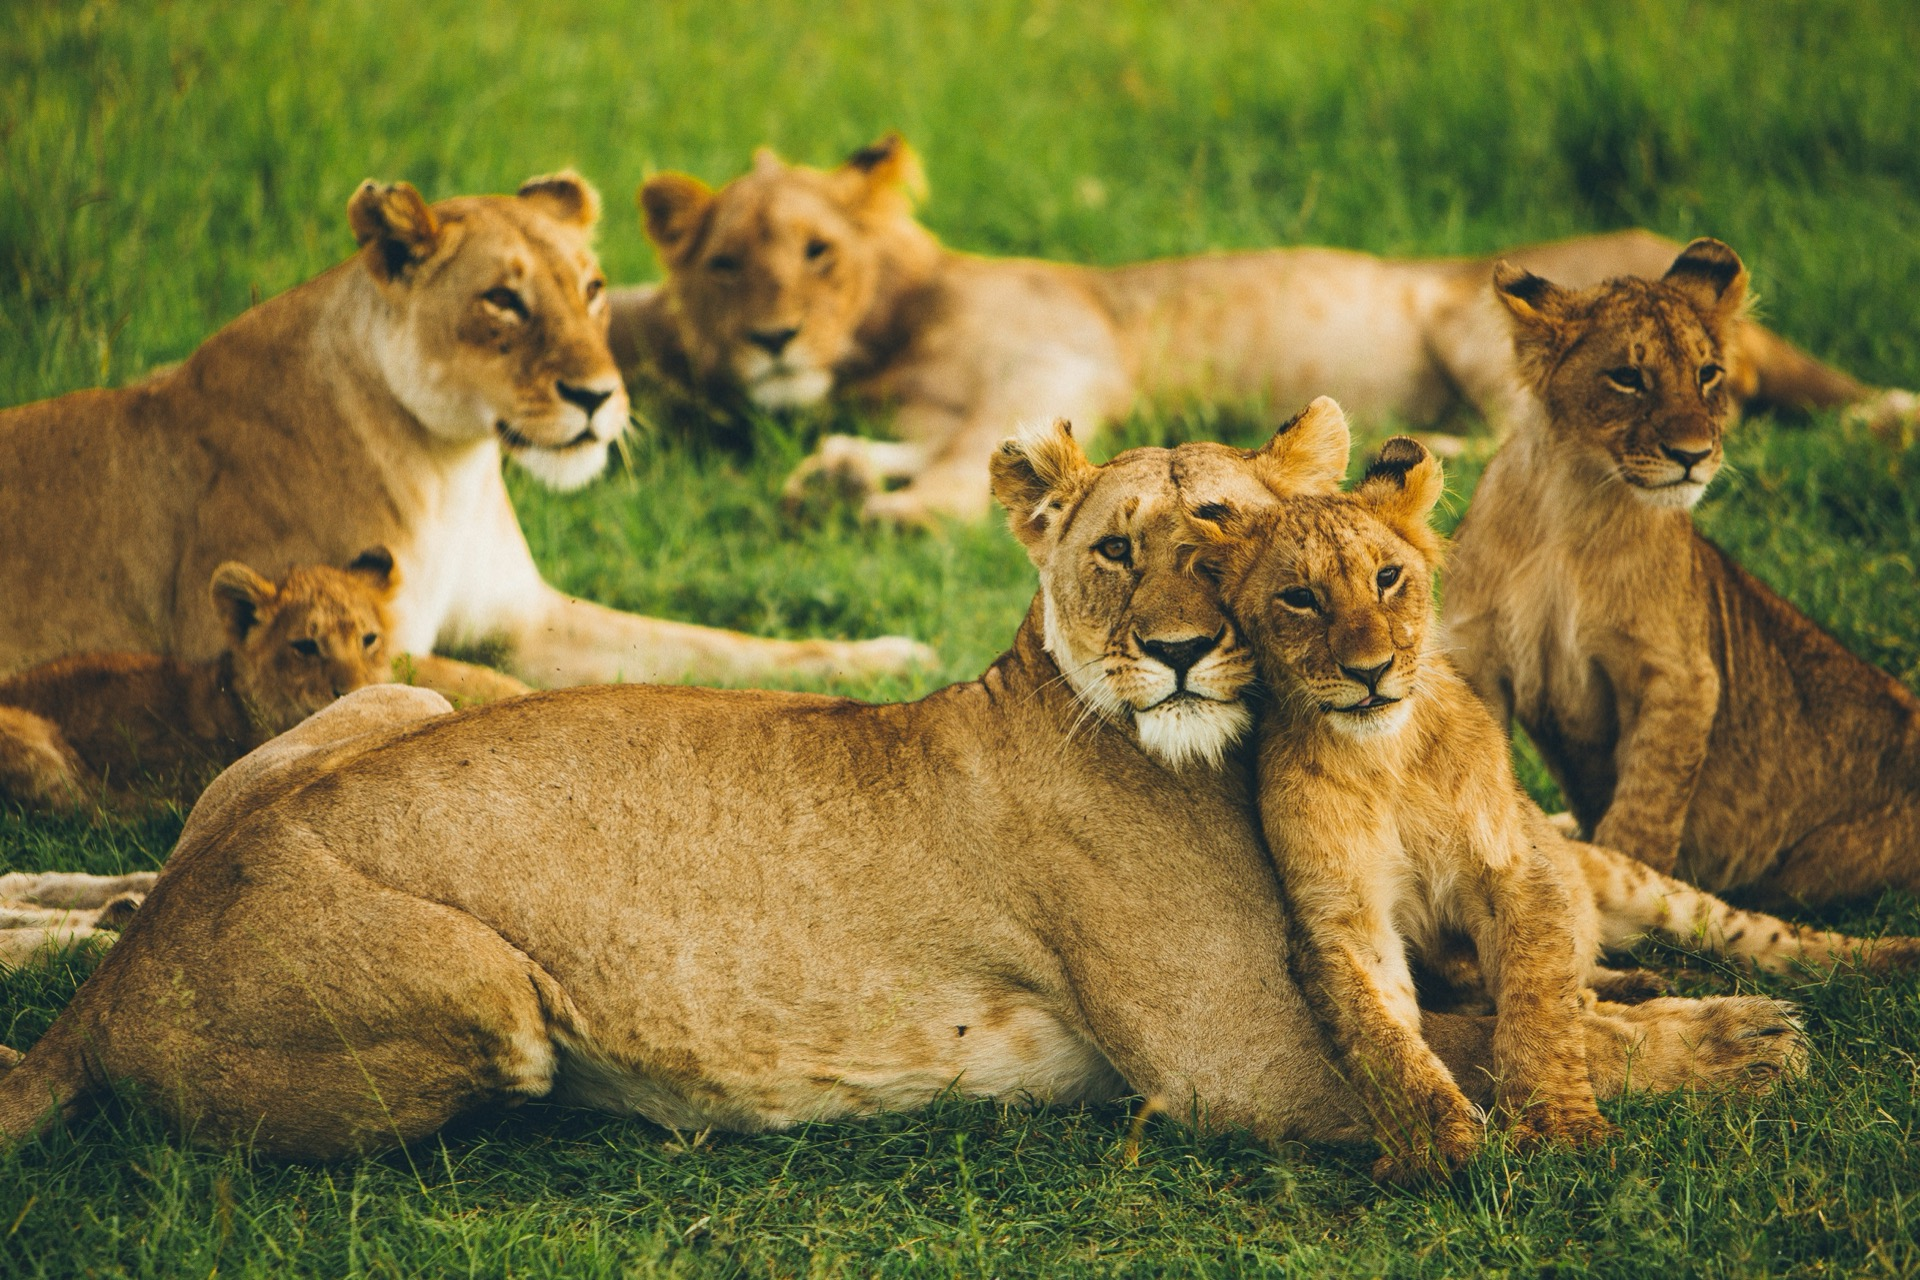

In [6]:
from IPython.display import Image

lions_image = f"{IMAGES_DIR}/lions.jpg"
Image(lions_image, width=600)

This image presents a unique challenge for drawing bounding boxes due to its composition. Some lions are sharply in focus, while others, like the one in the background, are less distinct. Additionally, the cub in the bottom left is partially hidden. The overlapping positions of the lions further complicate the task.

In [7]:
print(analyze_image(lions_image, "How many lions are in this picture?"))

There are six lions in the picture.


Nice, but let's try something a bit more specific to really test Grok's visual understanding capabilities.

In [8]:
print(
    analyze_image(
        lions_image, "How many lions are in this picture? Are they male, female, cubs?"
    )
)

In the picture, there are six lions:

1. **Adult Lioness**: The lion on the far left, which appears to be a female.
2. **Adult Lioness**: The lion in the center, also a female.
3. **Cub**: The small lion on the left side, next to the first adult lioness.
4. **Cub**: The lion in the front, cuddling with the central adult lioness.
5. **Cub**: The lion on the far right, standing.
6. **Adult Lioness**: The lion in the background, lying down.

So, there are three adult females and three cubs. There are no male lions visible in this picture.


Not bad.

## Detecting Objects in a Complex Scene

So we’ve demonstrated Grok’s spatial awareness; let’s see if we can take it to the next level and have it output bounding box coordinates for a given image, starting with the challenging lions image.

### Approach
In order to do this, we'll use a two stage approach, we'll first ask Grok to output the coordinates of the bounding boxes in text form, then we'll take that text and ask Grok to parse it into a well defined pydantic class using the [structured outputs](https://docs.x.ai/docs/guides/structured-outputs) feature, to make working with it easier.

In [9]:
from pydantic import BaseModel


class BoundingBox(BaseModel):
    object_name: str
    y1: float
    x1: float
    y2: float
    x2: float


class BoundingBoxes(BaseModel):
    boxes: list[BoundingBox]

In [10]:
def generate_bounding_boxes(
    client: OpenAI,
    image_path: str,
    user_query: str,
    object_detection_prompt: str,
) -> BoundingBoxes:
    prompt_with_instructions = object_detection_prompt.format(
        USER_INSTRUCTIONS=user_query
    )

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{base64_encode_image(image_path)}",
                        "detail": "high",
                    },
                },
                {"type": "text", "text": prompt_with_instructions},
            ],
        },
    ]

    completion = client.chat.completions.create(
        model=GROK_VISION_MODEL, messages=messages
    )

    if not completion.choices[0].message.content:
        raise ValueError("Expected message content on response was not found")

    semi_structured_response = completion.choices[0].message.content

    completion = client.beta.chat.completions.parse(
        model=GROK_MODEL,
        messages=[
            {
                "role": "user",
                "content": f"What are the coordinates of all bounding boxes: {semi_structured_response}",
            }
        ],
        response_format=BoundingBoxes,
    )

    bounding_boxes = completion.choices[0].message.parsed
    if not bounding_boxes:
        raise ValueError("No bounding boxes extracted")

    return bounding_boxes

In [11]:
import random

import cv2
from IPython.display import Image, display


def draw_bounding_boxes(
    image_path: str,
    bounding_boxes: BoundingBoxes,
    box_thickness: int = 8,
    label_size: float = 1.0,
) -> None:
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image file: {image_path}")

    height, width, _ = image.shape

    for box in bounding_boxes.boxes:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        start_point = (int(box.x1 * width), int(box.y1 * height))
        end_point = (int(box.x2 * width), int(box.y2 * height))

        image = cv2.rectangle(image, start_point, end_point, color, box_thickness)
        label = box.object_name

        text_thickness = max(1, int(label_size * 1.5))
        label_dimensions, _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, label_size, text_thickness
        )
        label_position = (start_point[0], start_point[1] - 20)

        # Adjust the background rectangle dynamically based on label dimensions
        cv2.rectangle(
            image,
            (label_position[0], label_position[1] - label_dimensions[1] - 6),
            (label_position[0] + label_dimensions[0], label_position[1] + 6),
            color,
            -1,
        )

        cv2.putText(
            image,
            label,
            label_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            label_size,
            (0, 0, 0),
            text_thickness,
            cv2.LINE_AA,
        )

    display(Image(data=cv2.imencode(".jpg", image)[1].tobytes(), width=600))

In [12]:
def detect_objects(
    grok_client: OpenAI,
    image_path: str,
    user_prompt: str,
    object_detection_prompt: str,
) -> None:
    bounding_boxes = generate_bounding_boxes(
        grok_client, image_path, user_prompt, object_detection_prompt
    )
    draw_bounding_boxes(image_path, bounding_boxes)

In [13]:
object_detection_prompt = """
You are an AI assistant specialized in object detection and drawing accurate bounding boxes. Your task is to generate normalized coordinates for bounding boxes based on given instructions and an image.


The coordinates for the bounding boxes should be normalized relative to the width and height of the image. This means:
- The top-left corner of the image is (0, 0)
- The bottom-right corner of the image is (1, 1)
- X-coordinates increase from left to right
- Y-coordinates increase from top to bottom

Now, here are the specific instructions for object detection:
<instructions>
{USER_INSTRUCTIONS}
</instructions>

Your output should be in the following format:
<bounding_box>
  <object>Name of the object</object>
  <coordinates>
    <top_left>(x1, y1)</top_left>
    <bottom_right>(x2, y2)</bottom_right>
  </coordinates>
</bounding_box>

If there are multiple objects to detect, provide separate <bounding_box> entries for each object. Focus on identifying the coordinates for one object before moving on to the next.

Here's an example of a good output:
<bounding_box>
  <object>Cat</object>
  <coordinates>
    <top_left>(0.2, 0.3)</top_left>
    <bottom_right>(0.5, 0.7)</bottom_right>
  </coordinates>
</bounding_box>
<bounding_box>
  <object>Dog</object>
  <coordinates>
    <top_left>(0.6, 0.4)</top_left>
    <bottom_right>(0.9, 0.8)</bottom_right>
  </coordinates>
</bounding_box>

If you cannot detect an object mentioned in the instructions, or if the instructions are unclear, include an explanation in your response:
<error>Unable to detect [object name] because [reason]</error>

Remember to be as accurate as possible when determining the coordinates. If you're unsure about the exact position of an object, use your best judgment to provide the most reasonable estimate.

Begin your object detection and bounding box coordinate generation now, based on the provided image and instructions.
"""

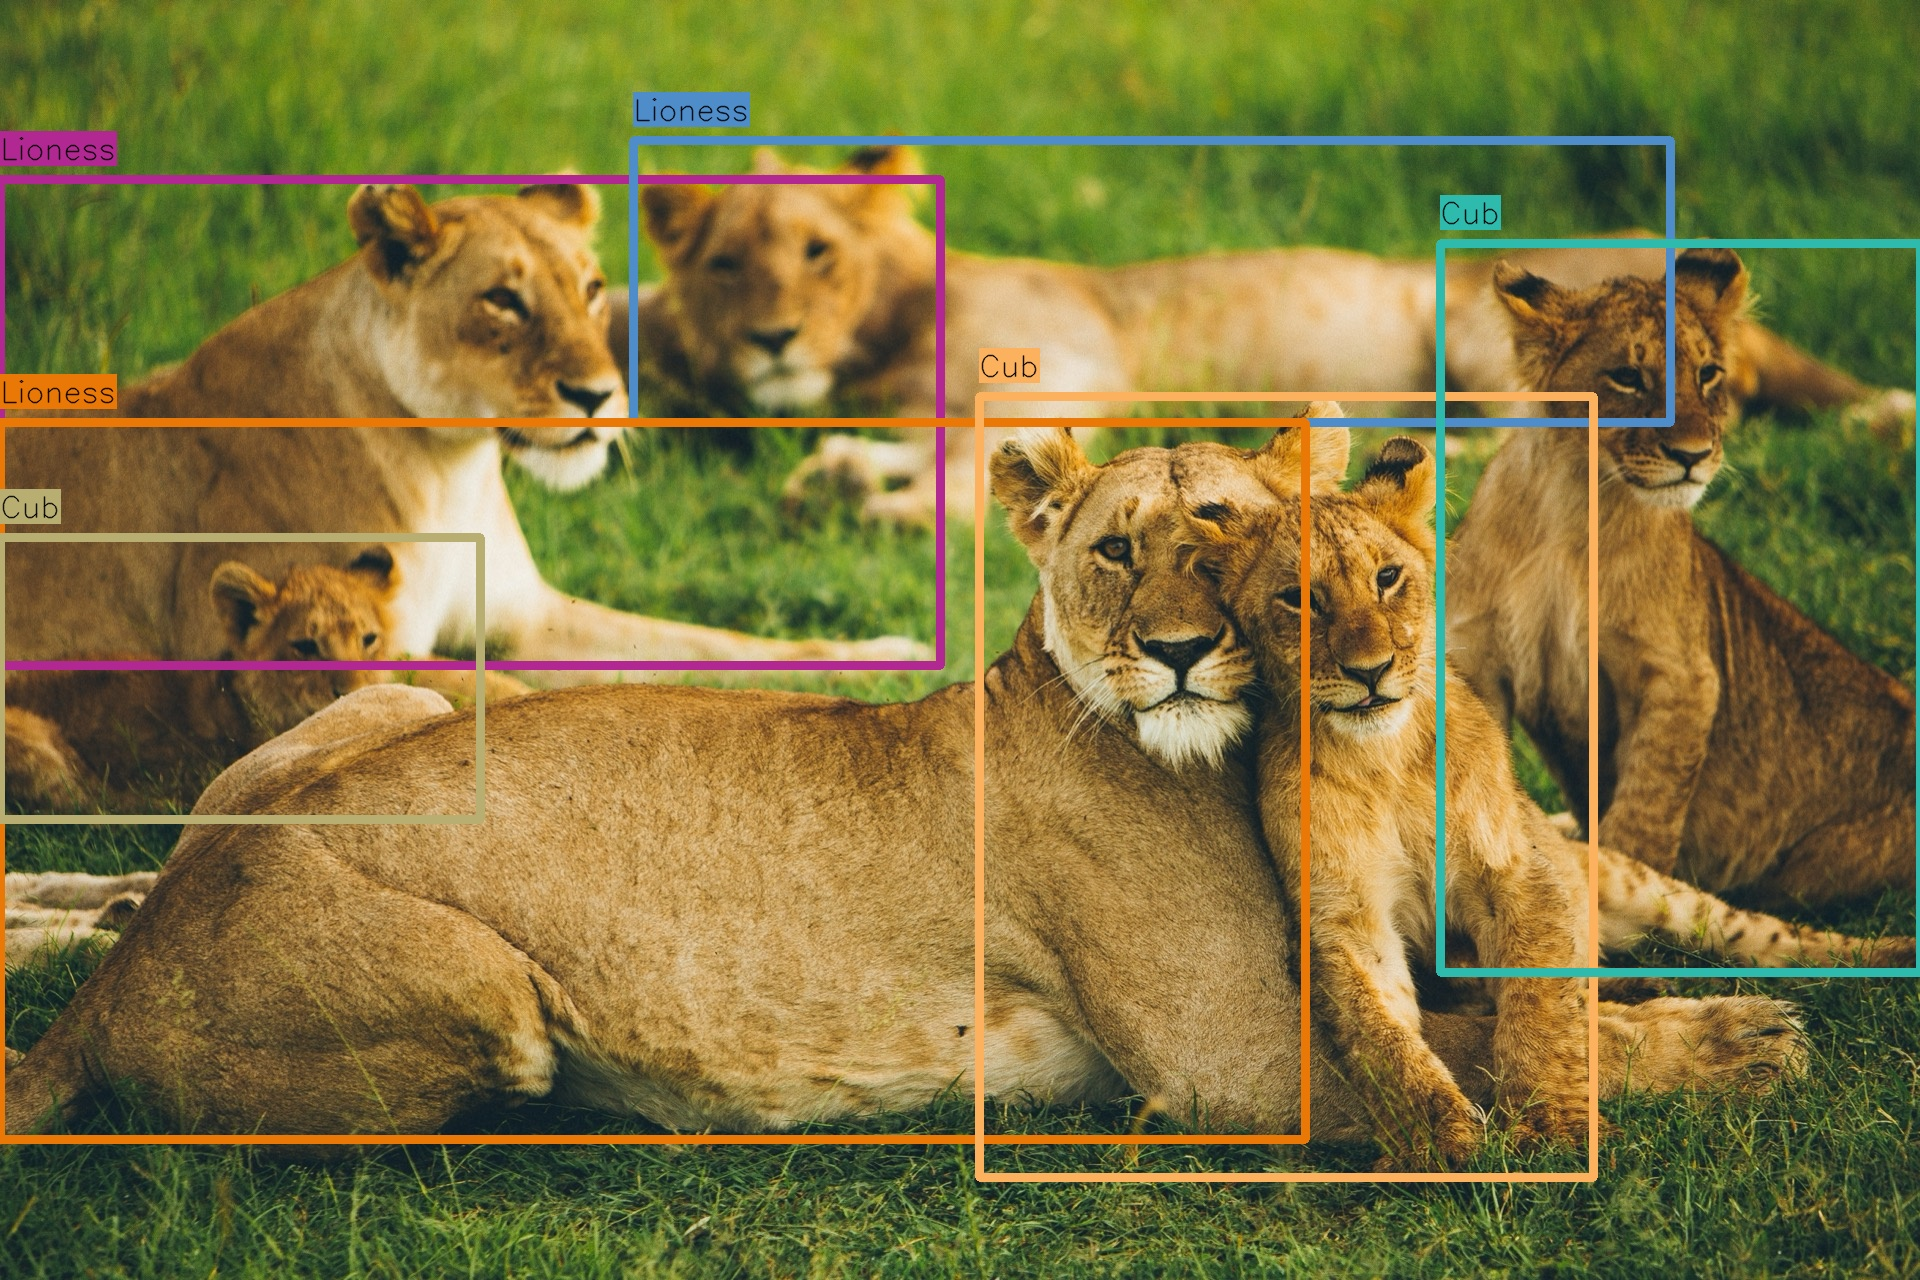

In [14]:
detect_objects(
    grok_client,
    lions_image,
    user_prompt="Detect all the lions, lionesses and cubs in this image",
    object_detection_prompt=object_detection_prompt,
)

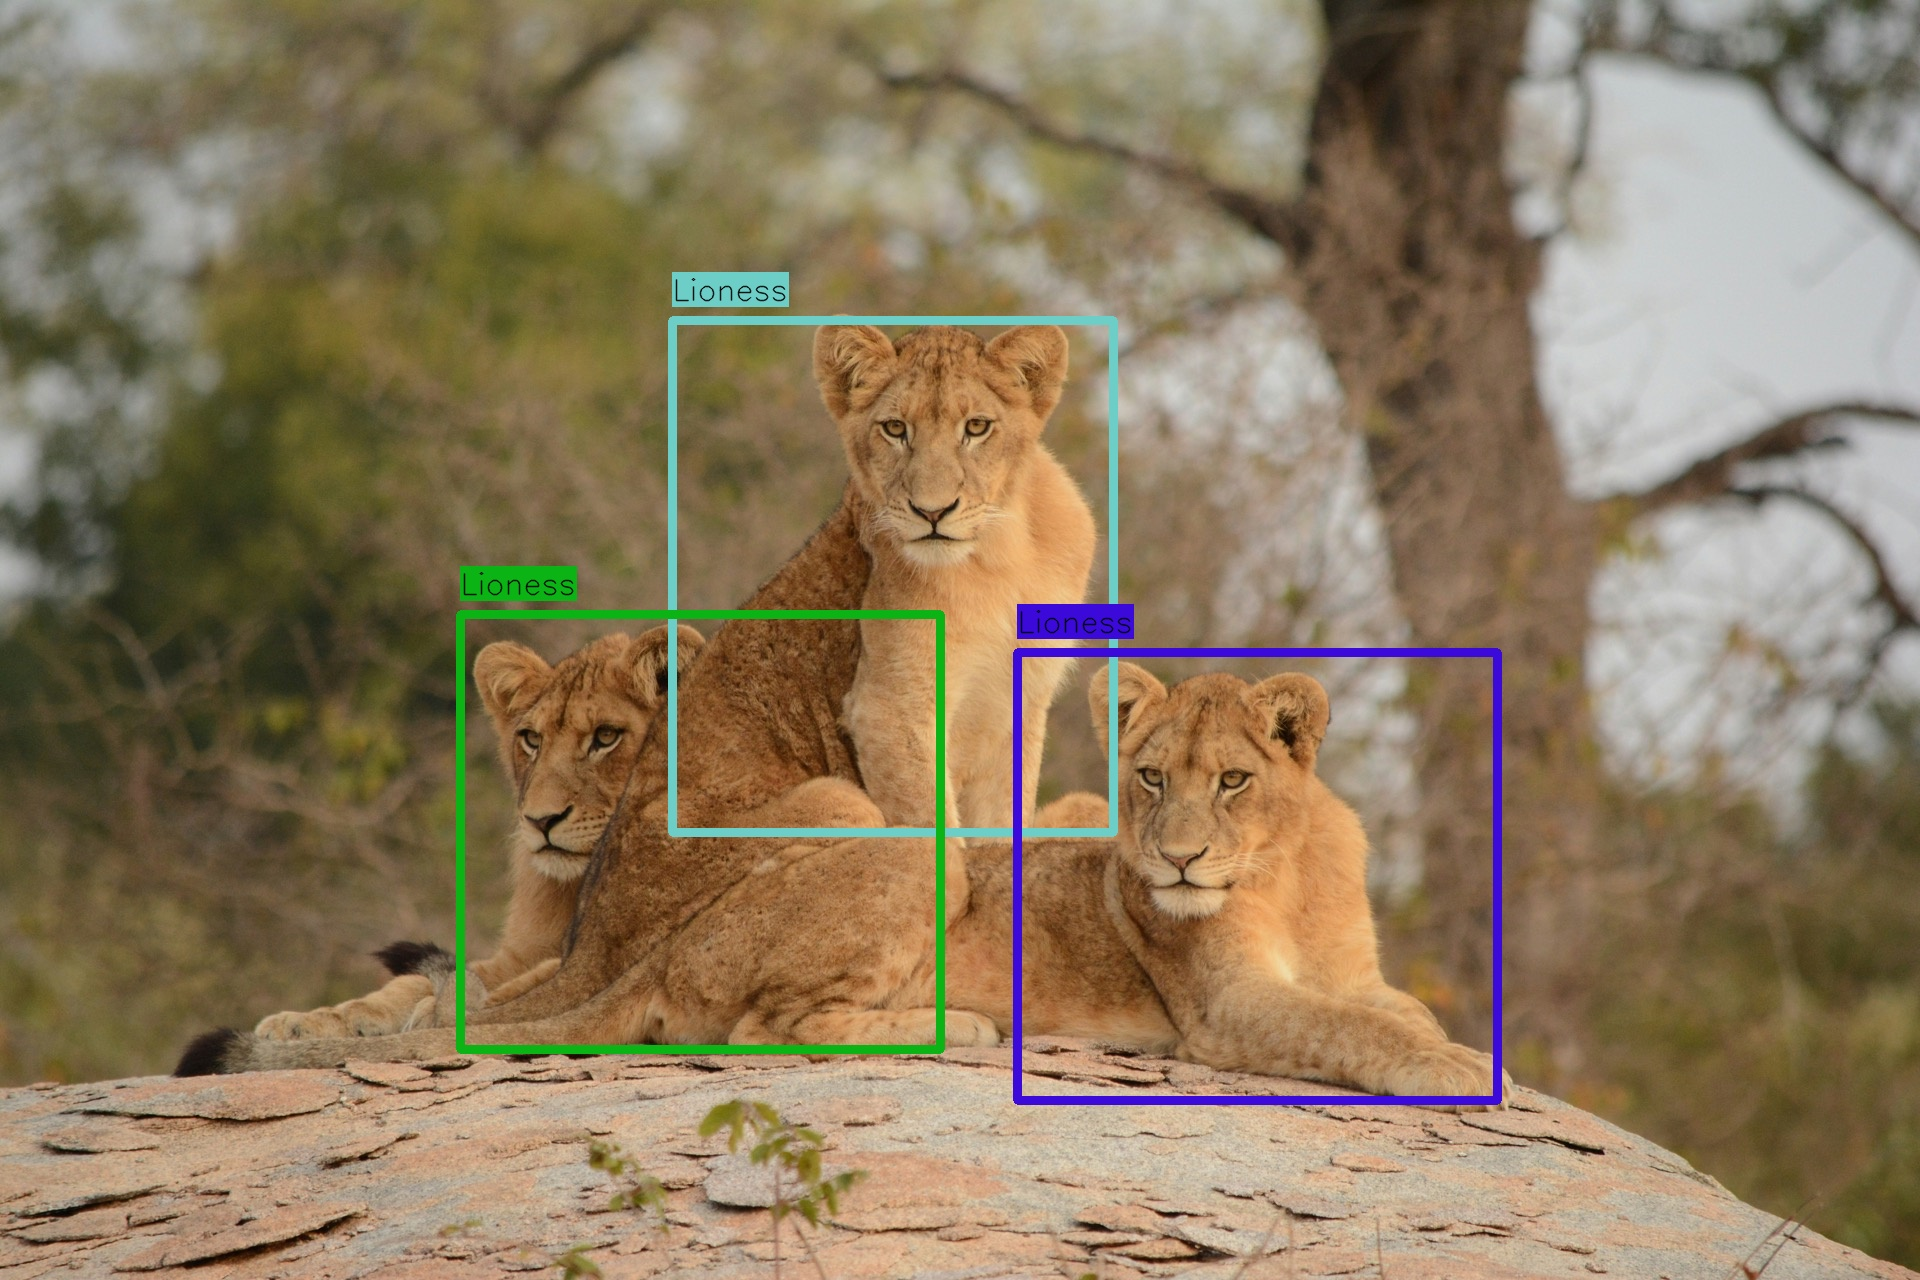

In [ ]:
lionesses_image = f"{IMAGES_DIR}/lionesses.jpg"

detect_objects(
    grok_client,
    lionesses_image,
    user_prompt="Detect all the lionesses in this image",
    object_detection_prompt=object_detection_prompt,
)

Pretty Impressive!

## The Power of Vision-Based Object Detection

So far, we've just been detecting a common animal such as a lion, let's really showcase how combining vision unlocks capabilities outside the realm of traditional vision models.

### Niche object detection

The image below contains many cars, but the main car in frame is a Cybertruck. Unless specifically in the training data, most traditional vision models wouldn’t know what a Cybertruck is and would either label this with a generic label, such as 'Car' or 'Truck', making no distinction from the other cars present in the image.

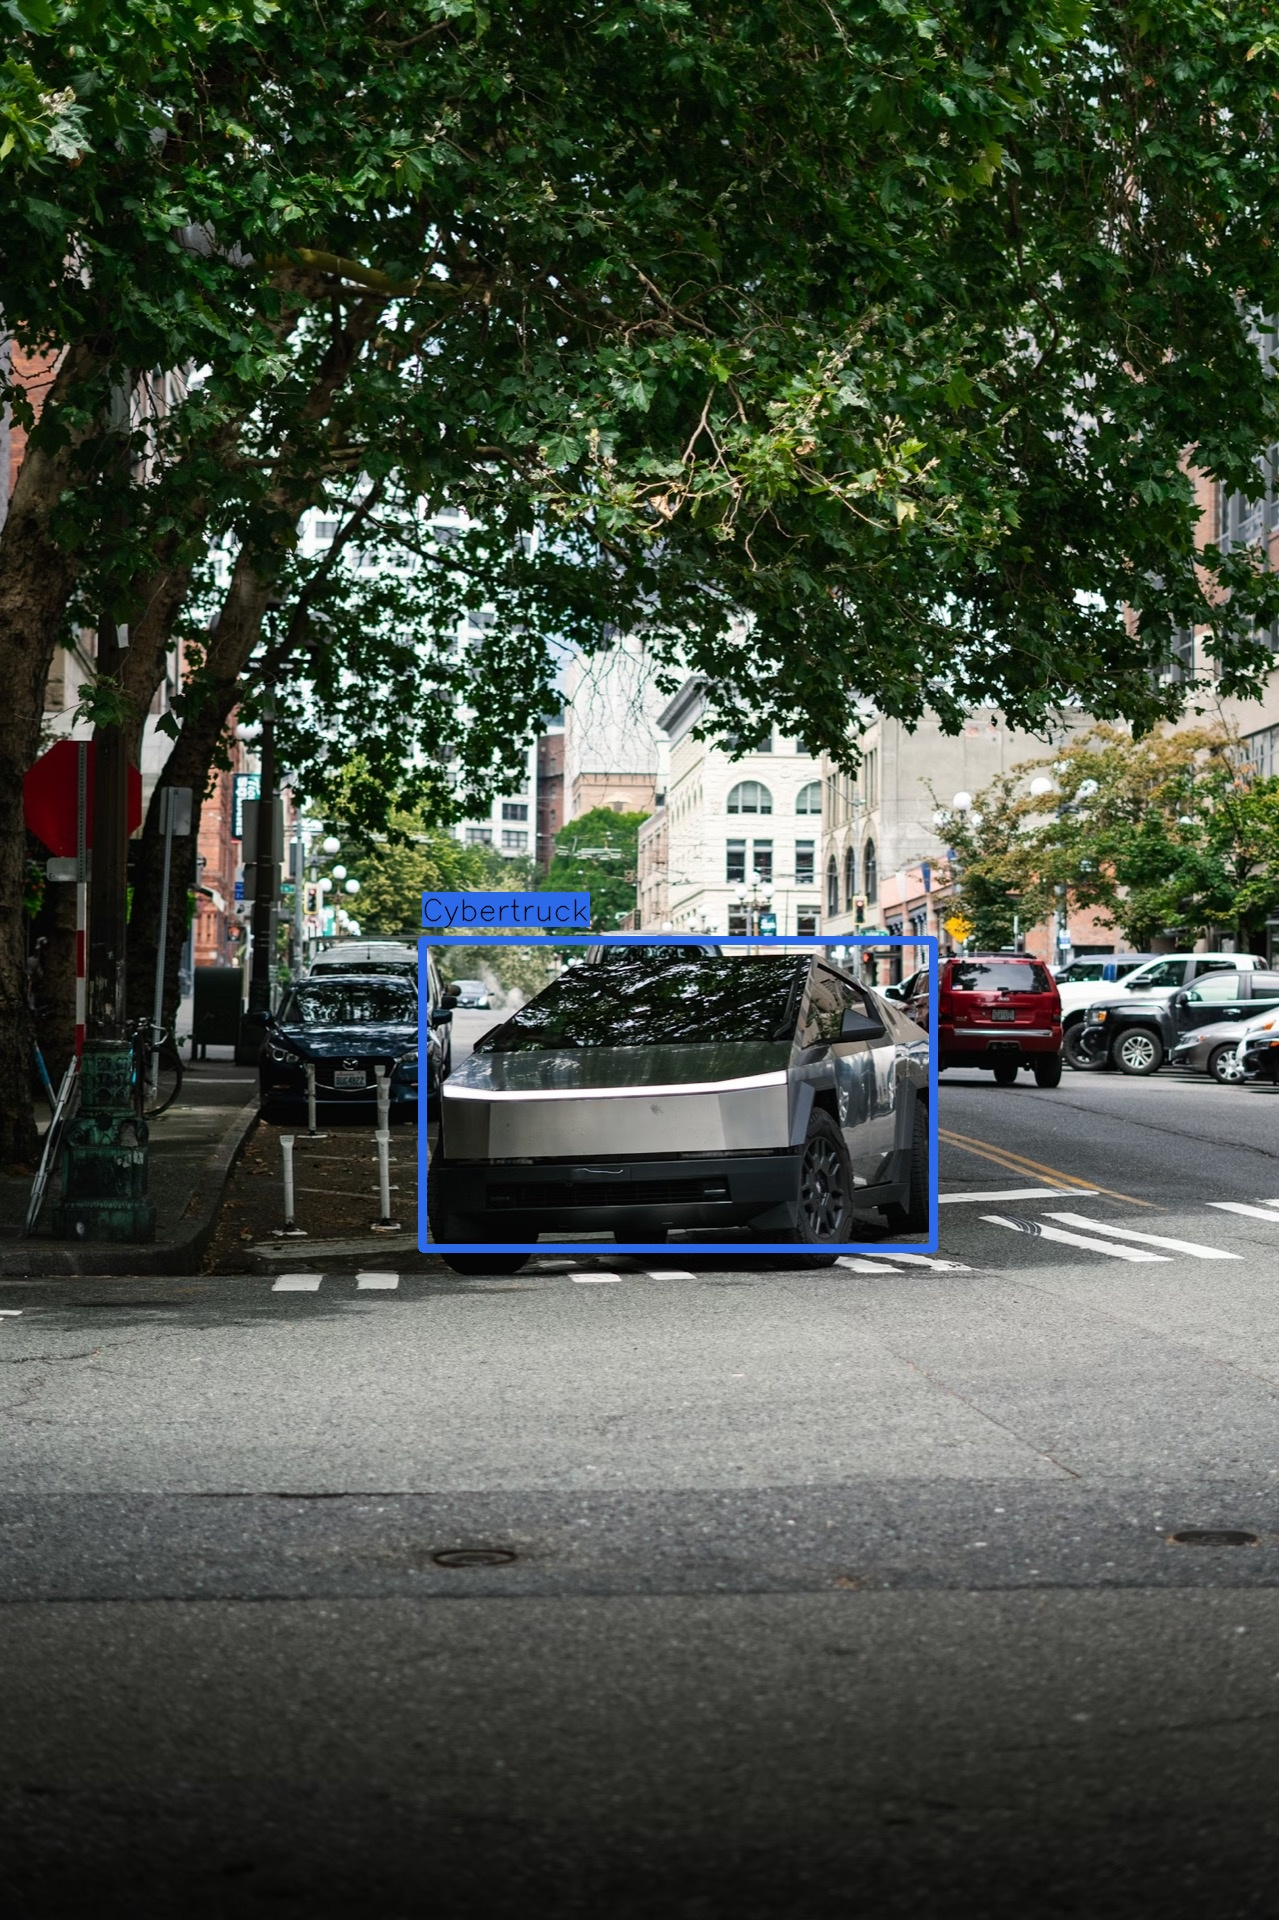

In [ ]:
cars_image = f"{IMAGES_DIR}/cybertruck.jpg"

bounding_boxes = detect_objects(
    grok_client,
    cars_image,
    user_prompt="Detect only the Cybertruck in the photo",
    object_detection_prompt=object_detection_prompt,
)

Nice. Let's push this concept further and try to only detect a specific model of a specific brand of car (Tesla).

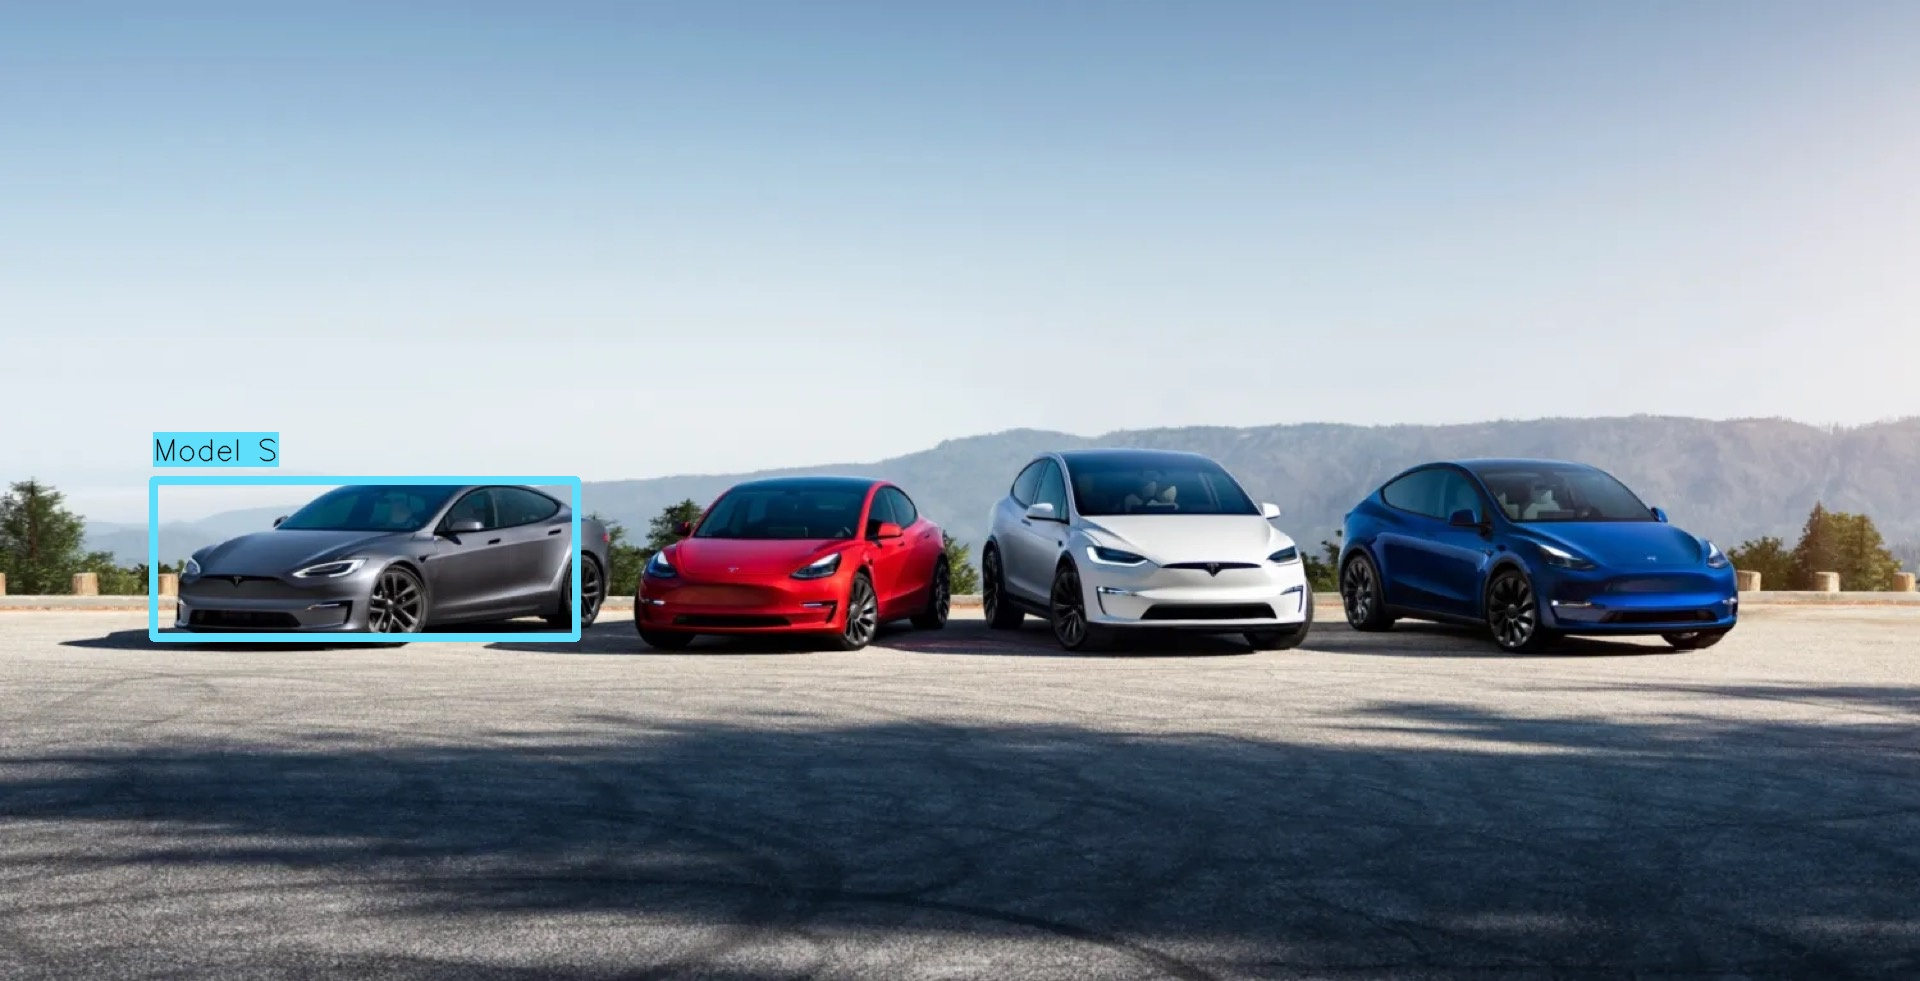

In [17]:
teslas = f"{IMAGES_DIR}/teslas.jpg"

bounding_boxes = generate_bounding_boxes(
    grok_client,
    teslas,
    user_query="Identify only the Model S in this photo",
    object_detection_prompt=object_detection_prompt,
)

draw_bounding_boxes(teslas, bounding_boxes)

Pretty cool!

### Applying Arbitrary Criteria

Let’s apply arbitrary, on-the-fly criteria to the objects we want to detect and those we want to filter out; here, we’re only detecting penguins if they’re lying down.

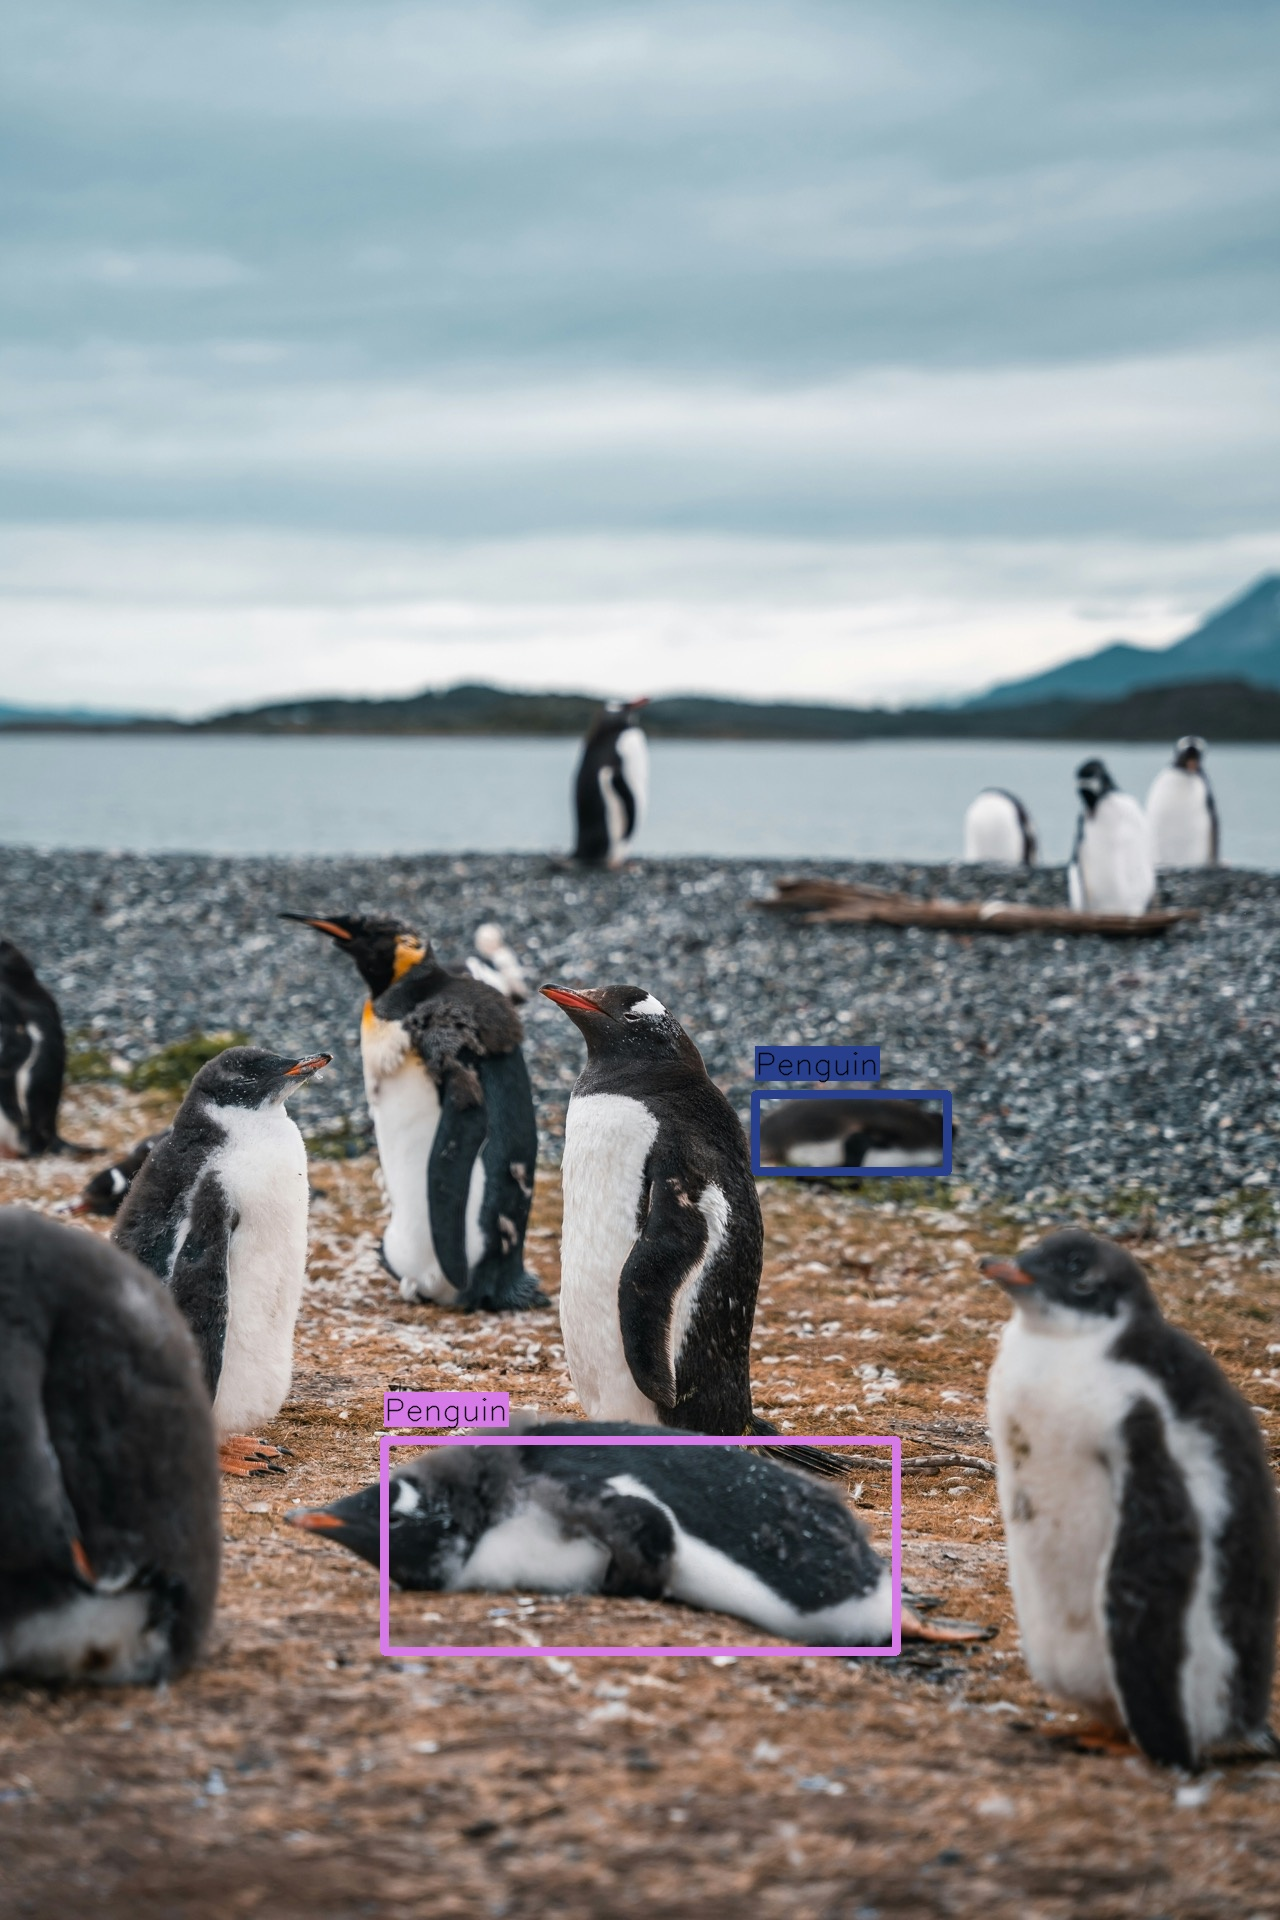

In [ ]:
penguins = f"{IMAGES_DIR}/penguins.jpg"

bounding_boxes = generate_bounding_boxes(
    grok_client,
    penguins,
    user_query="Identify only the penguins that are lying down in this photo",
    object_detection_prompt=object_detection_prompt,
)

draw_bounding_boxes(penguins, bounding_boxes)

### Text in Images with Multilingual Awareness

Here's an example asking Grok to detect only Arabic or Turkish text in an image containing a few different languages.

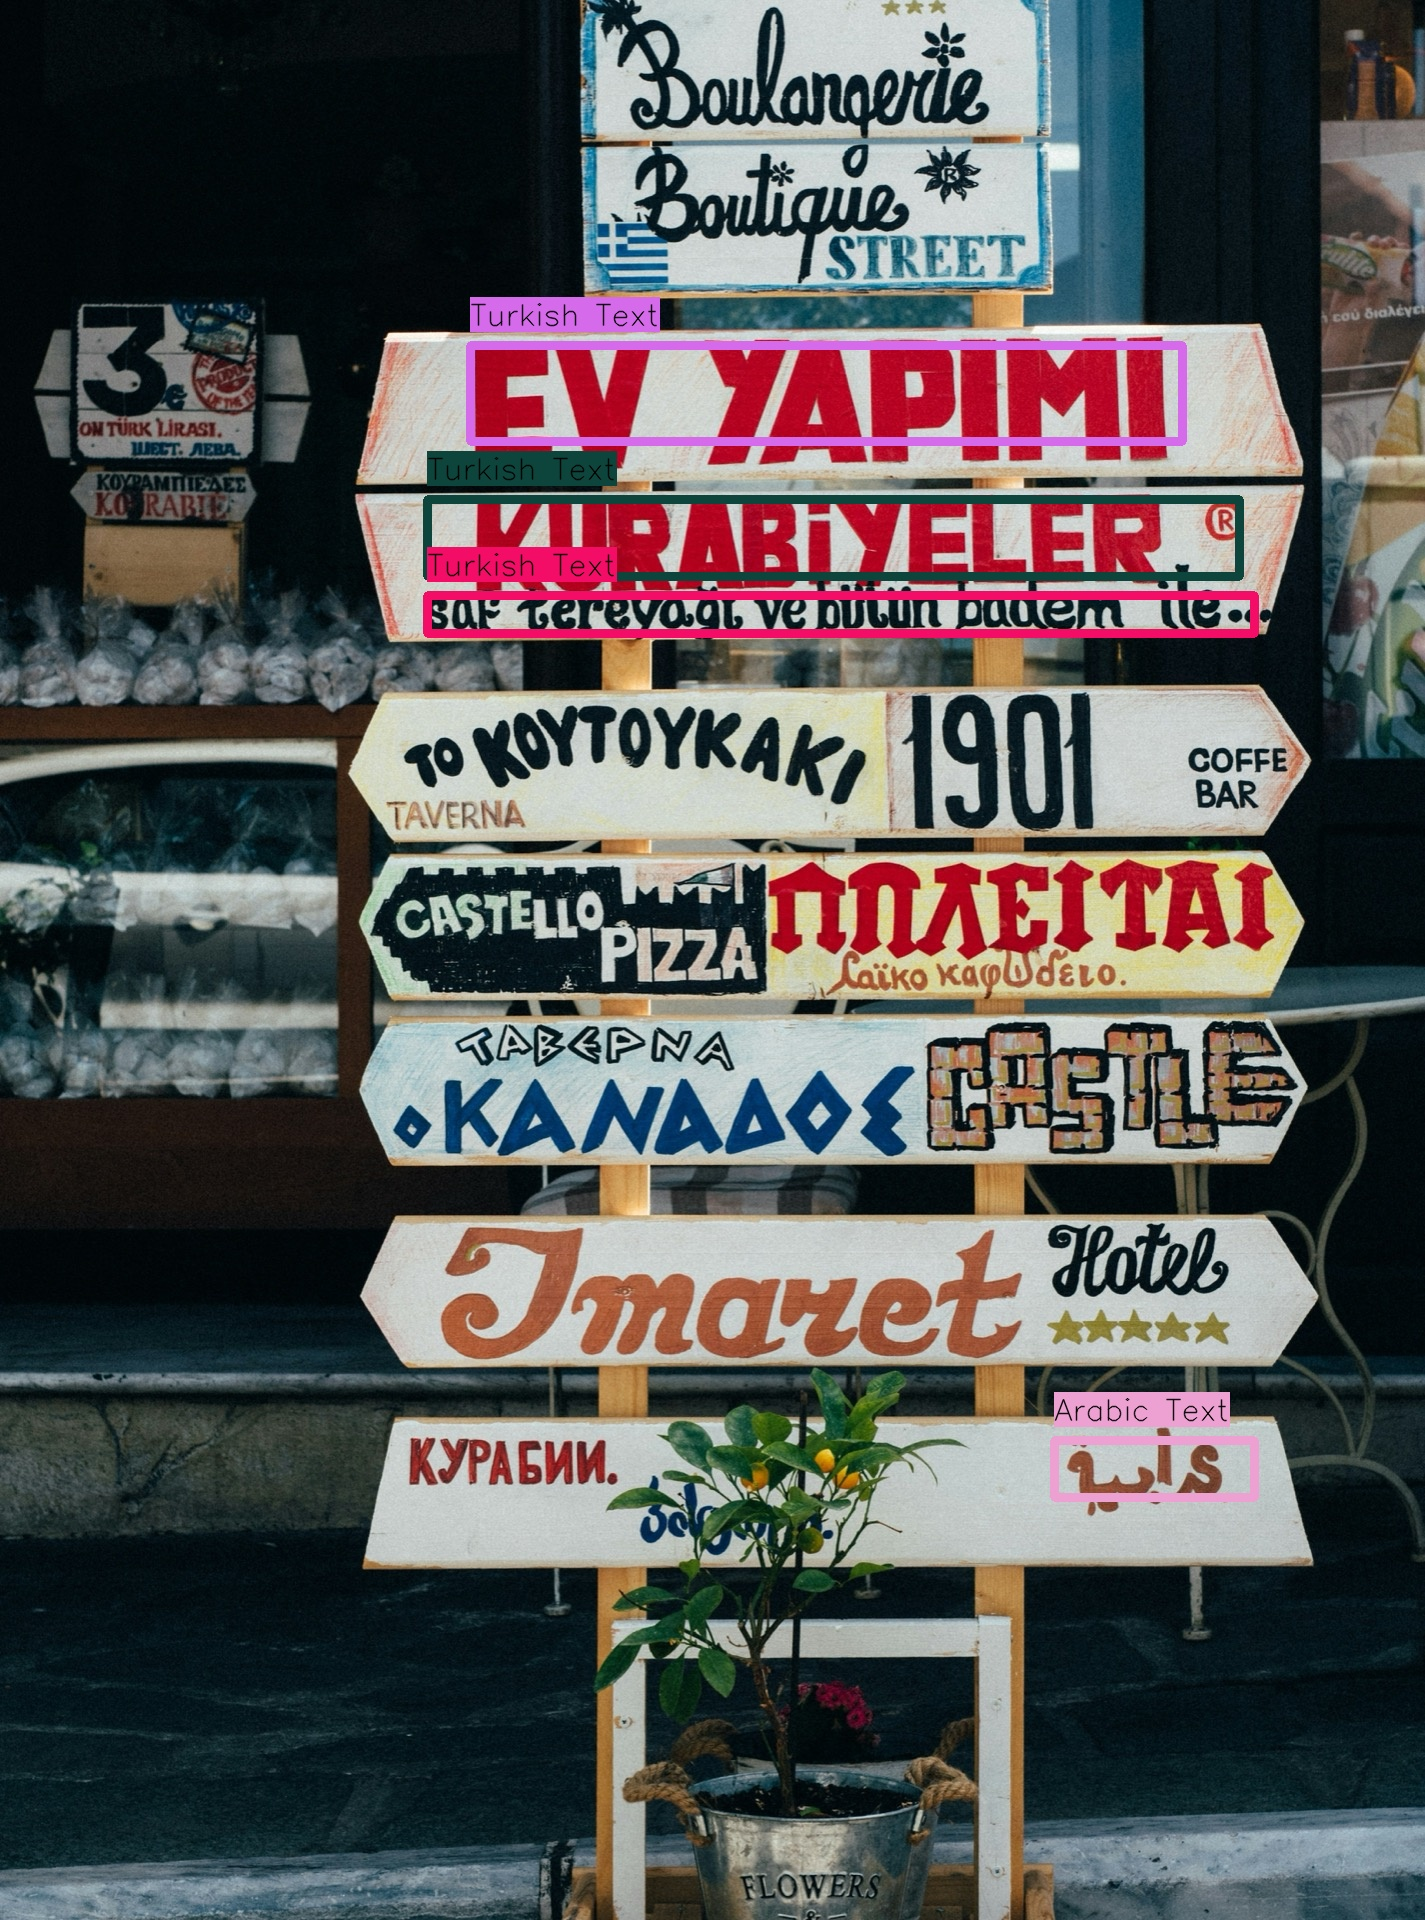

In [19]:
multilingual_signs = f"{IMAGES_DIR}/multi-lingual.jpg"

bounding_boxes = generate_bounding_boxes(
    grok_client,
    multilingual_signs,
    user_query="Identify only Arabic or Turkish text on the signs",
    object_detection_prompt=object_detection_prompt,
)

draw_bounding_boxes(multilingual_signs, bounding_boxes)

## Conclusion
The examples in this notebook highlight the power of vision-based object detection, which leverages the vast world knowledge of large language models to identify nearly anything expressible in language. However, due to the stochastic nature of these models, results may not always be perfect bounding boxes might not be 100% accurate, and performance can vary when you run this notebook yourself, particularly with complex images. Nevertheless, the xAI team is dedicated to continuously refining our vision models, improving accuracy, spatial reasoning, and overall capability with each iteration - see the [xAI API docs](https://docs.x.ai) to stay up to date with our latest model releases. We invite you to explore this approach further and discover the exciting applications you can create by pushing its boundaries.